# Trabajo final
Freddy Rodrigo Mendoza Ticona, frmendozat@uni.pe

Problema: Clasificación de imagenes
dataset: https://www.kaggle.com/c/flower-classification-with-tpus (TFRecords), https://www.kaggle.com/datasets/msheriey/104-flowers-garden-of-eden (version JPEG)


Modelos:
* Modelo base, red convolucional
* Resnet34
* Resnet50 
* Vision Transformer (base-sized model)



In [1]:
from fastai.vision import *
!pip install roboflow
from roboflow import Roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary

!pip install torchmetrics
import torchmetrics

from PIL import Image
import glob

import math, re, os, sys
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Descargando Dataset
tutorial: https://medium.com/analytics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [4]:
# %cd /content/drive/MyDrive/kaggle/
%cd /content/

/content


In [ ]:
# %cd /content/drive/MyDrive/kaggle/

In [6]:
!kaggle datasets download -d msheriey/104-flowers-garden-of-eden --unzip

 99% 1.73G/1.75G [00:14<00:00, 128MB/s]
100% 1.75G/1.75G [00:14<00:00, 133MB/s]


In [2]:
%ls

jpeg-192x192/  jpeg-311x311/  kaggle.json
jpeg-224x224/  jpeg-512x512/  sample_data/


In [8]:
#DATASET_DIR = '/content/drive/MyDrive/kaggle/jpeg-192x192'
DATASET_DIR = '/content/jpeg-192x192'
TRAIN_DIR  = DATASET_DIR + '/train'
VAL_DIR  = DATASET_DIR + '/val'
TEST_DIR  = DATASET_DIR + '/test'


## Análisis Exploratorio

In [3]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        self.image_paths = glob.glob(path + '/*.jpeg')
        self.transform = transform
        self.path = path

    def __getitem__(self, index):
        x = Image.open(self.image_paths[index])
        if self.transform is not None:
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.image_paths)

In [ ]:
train_set = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=None)
valid_set = torchvision.datasets.ImageFolder(VAL_DIR, transform=None)
test_set = TestDataset(path=TEST_DIR)

In [ ]:
CLASSES = list(train_set.classes)
print(f'Labels de las clases: {CLASSES}')
print(f'Numero de clases: {len(CLASSES)}')

Labels de las clases: ['alpine sea holly', 'anthurium', 'artichoke', 'azalea', 'balloon flower', 'barberton daisy', 'bee balm', 'bird of paradise', 'bishop of llandaff', 'black-eyed susan', 'blackberry lily', 'blanket flower', 'bolero deep blue', 'bougainvillea', 'bromelia', 'buttercup', 'californian poppy', 'camellia', 'canna lily', 'canterbury bells', 'cape flower', 'carnation', 'cautleya spicata', 'clematis', "colt's foot", 'columbine', 'common dandelion', 'common tulip', 'corn poppy', 'cosmos', 'cyclamen ', 'daffodil', 'daisy', 'desert-rose', 'fire lily', 'foxglove', 'frangipani', 'fritillary', 'garden phlox', 'gaura', 'gazania', 'geranium', 'giant white arum lily', 'globe thistle', 'globe-flower', 'grape hyacinth', 'great masterwort', 'hard-leaved pocket orchid', 'hibiscus', 'hippeastrum ', 'iris', 'japanese anemone', 'king protea', 'lenten rose', 'lilac hibiscus', 'lotus', 'love in the mist', 'magnolia', 'mallow', 'marigold', 'mexican petunia', 'monkshood', 'moon orchid', 'mornin

### Descripción del conjunto de entrenamiento ###
Dataset ImageFolder
    Number of datapoints: 12753
    Root location: /content/jpeg-192x192/train
### Dimensiones de un ejemplo del dataset ###
(192, 192, 3)

### Descripción del conjunto de evaluación ###
Dataset ImageFolder
    Number of datapoints: 3712
    Root location: /content/jpeg-192x192/val

### Descripción del conjunto de test ###
Number of images: 7382, path: /content/jpeg-192x192/test

Label de la imágen 0: alpine sea holly
Label de la imágen 1: alpine sea holly
Label de la imágen 2: alpine sea holly
Label de la imágen 3: alpine sea holly
Label de la imágen 4: alpine sea holly
Label de la imágen 5: alpine sea holly
Label de la imágen 6: alpine sea holly
Label de la imágen 7: alpine sea holly
Label de la imágen 8: alpine sea holly


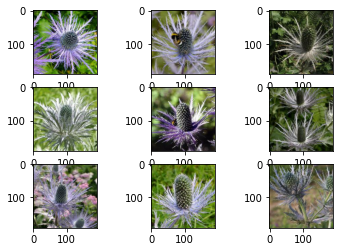

In [ ]:
print("### Descripción del conjunto de entrenamiento ###")
print(train_set)
print("### Dimensiones de un ejemplo del dataset ###")
print(np.shape(train_set[0][0]))

print("\n### Descripción del conjunto de evaluación ###")
print(valid_set)
print("\n### Descripción del conjunto de test ###")
print("Number of images: {}, path: {}\n".format(len(test_set), test_set.path))

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  image, label = train_set[i]
  plt.subplot(331 + i)
  plt.imshow(image)
  print("Label de la imágen {}: {}".format(i, CLASSES[label]))

plt.show()


In [ ]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

# def batch_to_numpy_images_and_labels(data):
#     images, labels = data
#     numpy_images = images.numpy()
#     numpy_labels = labels.numpy()
#     if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
#         numpy_labels = [None for _ in enumerate(numpy_images)]
#     # If no labels, only image IDs, return None for labels (this is the case for test data)
#     return numpy_images, numpy_labels

def batch_to_numpy_images_and_labels(data):

    img_list = []
    label_list = []
    for img, label in data:
      img_list.append(np.array(img))
      label_list.append(label)
    
    numpy_images = np.array(img_list)
    numpy_labels = np.array(label_list)
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    # zoom_pcent: X autoscales y axis for the last X% of data points
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation,'--')
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = len(training)*(100-zoom_pcent)//100
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
train_subset = torch.utils.data.Subset(train_set, np.random.choice(len(train_set), 100, replace=False))
display_batch_of_images(train_subset)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
valid_subset = torch.utils.data.Subset(valid_set, np.random.choice(len(valid_set), 100, replace=False))
display_batch_of_images(valid_subset)

Output hidden; open in https://colab.research.google.com to view.

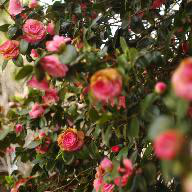

In [ ]:
test_subset = torch.utils.data.Subset(test_set, np.random.choice(len(test_set), 10, replace=False))
test_subset[0]

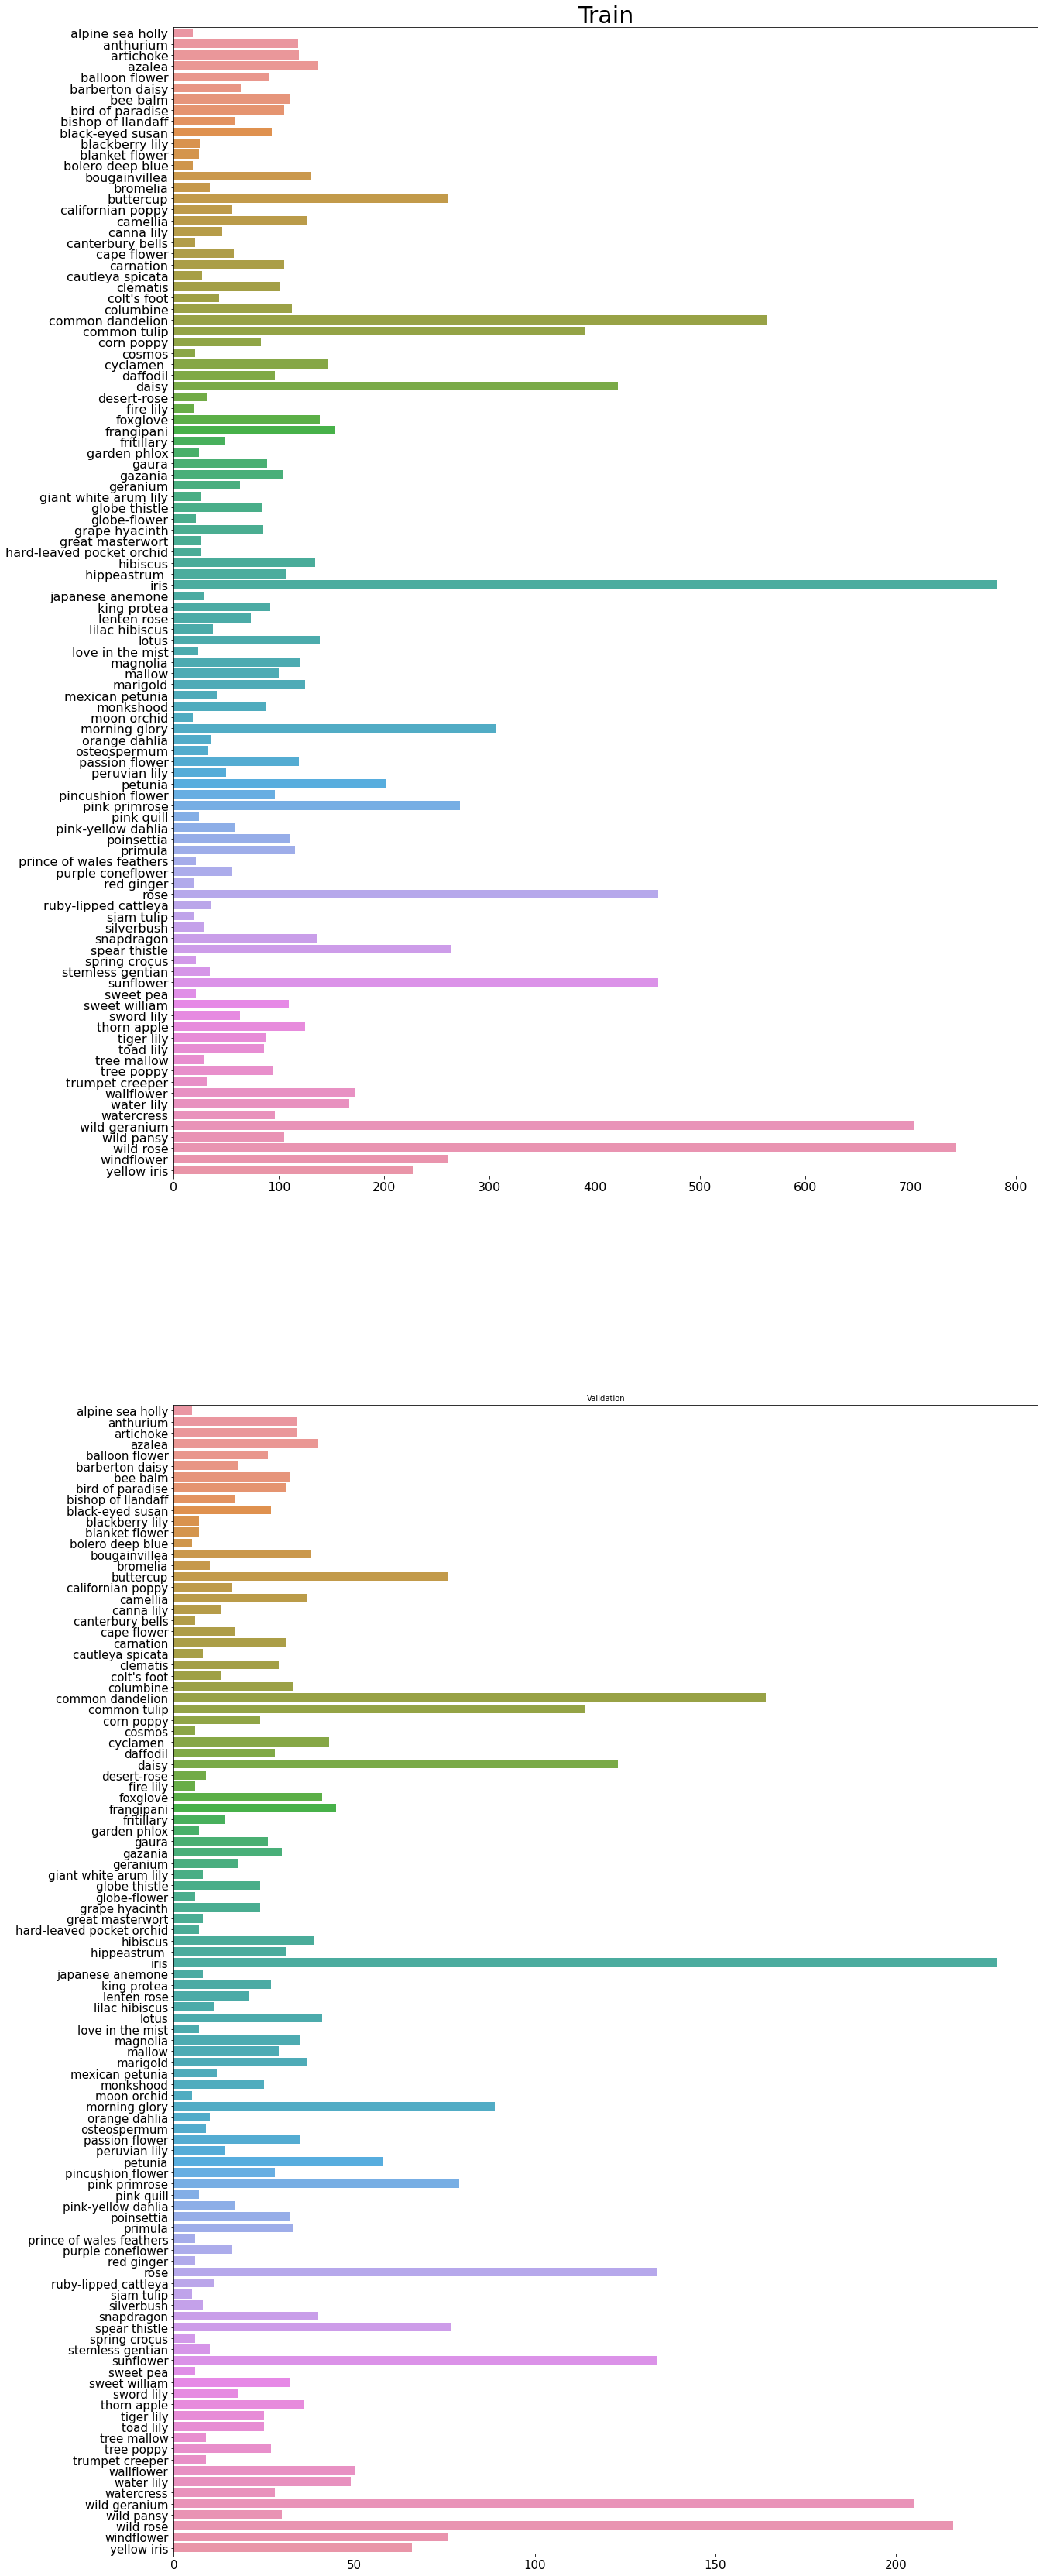

In [ ]:
import seaborn as sns

train_agg = np.array([[label, (np.array(train_set.targets) == index).sum()] for index, label in enumerate(CLASSES)])
valid_agg = np.array([[label, (np.array(valid_set.targets) == index).sum()] for index, label in enumerate(CLASSES)])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 60))

ax1 = sns.barplot(x=train_agg[...,1].astype(int), y=train_agg[...,0], order=CLASSES, ax=ax1)
ax1.set_title('Train', fontsize=30)
ax1.tick_params(labelsize=16)

ax2 = sns.barplot(x=valid_agg[...,1].astype(int), y=valid_agg[...,0], order=CLASSES, ax=ax2)
ax2.set_title('Validation', fontsize=10)
ax2.tick_params(labelsize=15)

plt.show()

## Crear Dataset y Dataloaders

In [ ]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

train_transform = torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(192),
                                      torchvision.transforms.RandomHorizontalFlip(0.5),
                                      torchvision.transforms.ToTensor(), normalize])

valid_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((192,192)),
                                      torchvision.transforms.ToTensor(), normalize])


test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize])


In [ ]:
train_set = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
valid_set = torchvision.datasets.ImageFolder(VAL_DIR, transform=valid_transform)
test_set = TestDataset(path=TEST_DIR, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2)


# print out some data stats
print('Num training images: ', len(train_set))
print('Num valid images: ', len(valid_set))
print('Num test images: ', len(test_set))


Num training images:  12753
Num valid images:  3712
Num test images:  7382


# Modelos

## Modelo Base

In [ ]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='valid')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='valid')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='valid')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='valid')
        self.fc1 = torch.nn.Linear(in_features=51200, out_features=104)
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.conv4(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

conv_model = ConvModel()
print(conv_model)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, input_size=(3, 192, 192))

ConvModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (fc1): Linear(in_features=51200, out_features=104, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 190, 190]             448
         MaxPool2d-2           [-1, 16, 95, 95]               0
            Conv2d-3           [-1, 32, 93, 93]           4,640
         MaxPool2d-4           [-1, 32, 

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        count = 0
        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()
        with torch.no_grad():
          epoch_valid_loss = 0.0
          epoch_valid_accuracy = 0.0

          for valid_data, valid_target in valid_loader:
              if torch.cuda.is_available():
                  valid_data = valid_data.to("cuda")
                  valid_target = valid_target.to("cuda")

              output = model(valid_data)
              epoch_valid_loss += criterion(output, valid_target).item()
              epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
              
          epoch_valid_loss = epoch_valid_loss / len(valid_loader)
          epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
          valid_loss.append(epoch_valid_loss)
          valid_acc.append(epoch_valid_accuracy)

          print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
              epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history


In [ ]:
conv_model_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)
conv_model_loss = torch.nn.CrossEntropyLoss()
conv_model_accuracy = torchmetrics.Accuracy()

In [ ]:
result_model, history = train(conv_model, conv_model_loss, conv_model_optimizer, train_loader, valid_loader, 50)

Epoch: 1/50 - Train loss 3.488036 - Train Accuracy 0.150861 - Valid Loss 3.072180 - Valid Accuracy 0.235453
Epoch: 2/50 - Train loss 3.073424 - Train Accuracy 0.223407 - Valid Loss 2.892624 - Valid Accuracy 0.264278
Epoch: 3/50 - Train loss 2.870721 - Train Accuracy 0.262025 - Valid Loss 2.650442 - Valid Accuracy 0.317619
Epoch: 4/50 - Train loss 2.747859 - Train Accuracy 0.296857 - Valid Loss 2.506067 - Valid Accuracy 0.342942
Epoch: 5/50 - Train loss 2.644545 - Train Accuracy 0.318321 - Valid Loss 2.400537 - Valid Accuracy 0.383890
Epoch: 6/50 - Train loss 2.557687 - Train Accuracy 0.334399 - Valid Loss 2.425506 - Valid Accuracy 0.366110
Epoch: 7/50 - Train loss 2.474291 - Train Accuracy 0.357655 - Valid Loss 2.374373 - Valid Accuracy 0.396821
Epoch: 8/50 - Train loss 2.395041 - Train Accuracy 0.374230 - Valid Loss 2.249179 - Valid Accuracy 0.419181
Epoch: 9/50 - Train loss 2.336396 - Train Accuracy 0.389868 - Valid Loss 2.213363 - Valid Accuracy 0.426185
Epoch: 10/50 - Train loss 2.

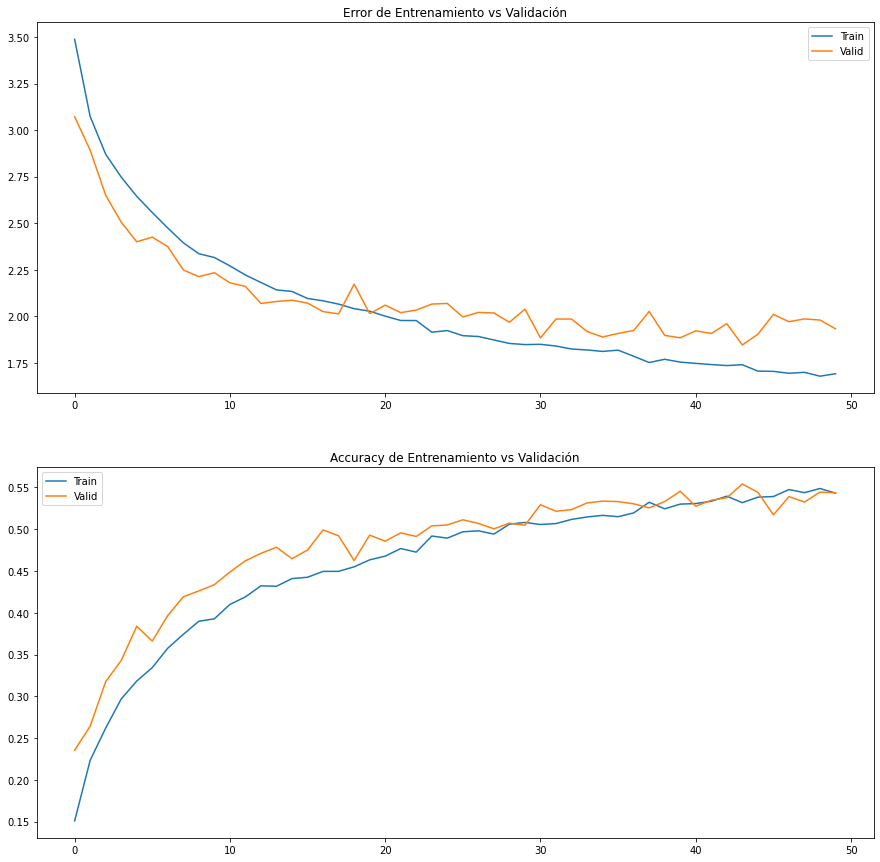

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

### Accuracy en validacion

In [ ]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

accuracy_metric = torchmetrics.Accuracy()
if torch.cuda.is_available():
  accuracy_metric.to("cuda")

for test_data, test_target in valid_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = conv_model(test_data)
  test_loss += conv_model_loss(output, test_target).item()
  test_accuracy += accuracy_metric(output, test_target).item()

test_loss = test_loss / len(valid_loader)
test_accuracy = test_accuracy / len(valid_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 1.933169 y una accuracy de 0.543642


## Resnet34


In [ ]:
resnet34_model = torchvision.models.resnet34(pretrained=True)
resnet34_model.modules

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
for param in resnet34_model.parameters():
    param.requires_grad = False

In [ ]:
last_layer_in_features = resnet34_model.fc.in_features
resnet34_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=104)

In [ ]:
optimizer_ft = torch.optim.Adam(resnet34_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
result_model, history = train(resnet34_model, criterion, optimizer_ft, train_loader, valid_loader, 80)

Epoch: 1/80 - Train loss 4.272947 - Train Accuracy 0.060597 - Valid Loss 3.979516 - Valid Accuracy 0.096175
Epoch: 2/80 - Train loss 3.812850 - Train Accuracy 0.145902 - Valid Loss 3.600026 - Valid Accuracy 0.190463
Epoch: 3/80 - Train loss 3.497575 - Train Accuracy 0.226096 - Valid Loss 3.284737 - Valid Accuracy 0.264278
Epoch: 4/80 - Train loss 3.221126 - Train Accuracy 0.286932 - Valid Loss 3.010832 - Valid Accuracy 0.322198
Epoch: 5/80 - Train loss 2.985758 - Train Accuracy 0.335763 - Valid Loss 2.775633 - Valid Accuracy 0.375808
Epoch: 6/80 - Train loss 2.799194 - Train Accuracy 0.386763 - Valid Loss 2.571480 - Valid Accuracy 0.417295
Epoch: 7/80 - Train loss 2.614738 - Train Accuracy 0.423585 - Valid Loss 2.412602 - Valid Accuracy 0.452586
Epoch: 8/80 - Train loss 2.471322 - Train Accuracy 0.456780 - Valid Loss 2.267845 - Valid Accuracy 0.483567
Epoch: 9/80 - Train loss 2.346071 - Train Accuracy 0.489177 - Valid Loss 2.137962 - Valid Accuracy 0.518588
Epoch: 10/80 - Train loss 2.

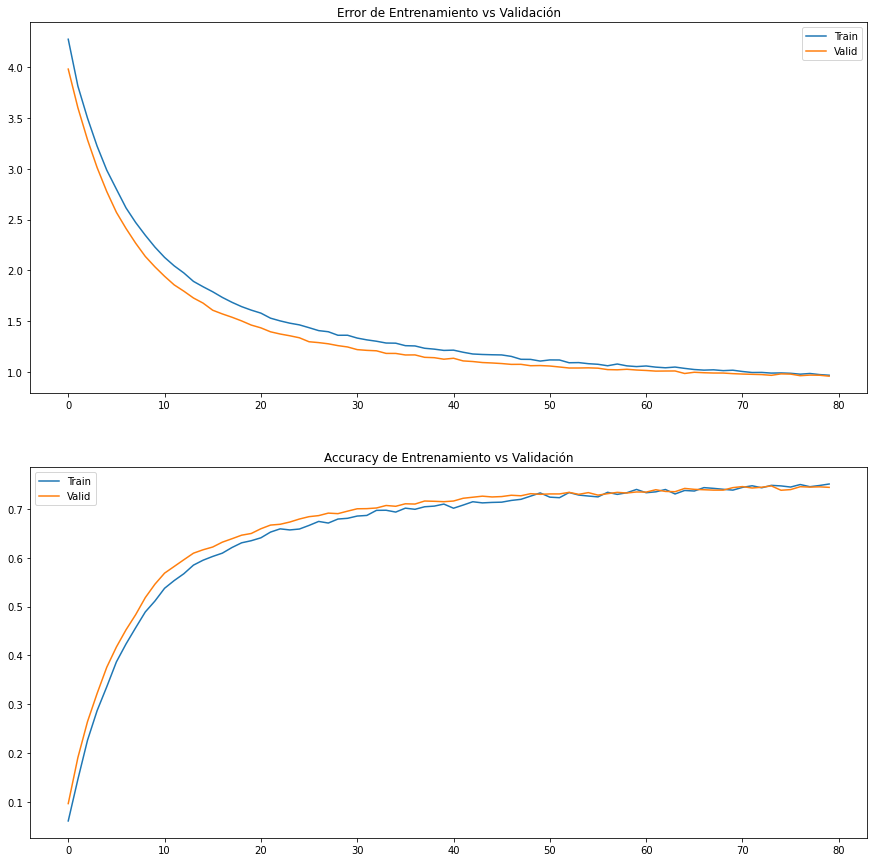

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

### Accuracy en validacion

In [ ]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

accuracy_metric = torchmetrics.Accuracy()
if torch.cuda.is_available():
  accuracy_metric.to("cuda")

for test_data, test_target in valid_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = resnet34_model(test_data)
  test_loss += criterion(output, test_target).item()
  test_accuracy += accuracy_metric(output, test_target).item()

test_loss = test_loss / len(valid_loader)
test_accuracy = test_accuracy / len(valid_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.960569 y una accuracy de 0.744612


## Resnet50

In [ ]:
resnet50_model = torchvision.models.resnet50(pretrained=True)
resnet50_model.modules

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

In [ ]:
for param in resnet50_model.parameters():
    param.requires_grad = False

In [ ]:
last_layer_in_features = resnet50_model.fc.in_features
resnet50_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=104)

In [ ]:
optimizer_ft = torch.optim.Adam(resnet50_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
result_model, history = train(resnet50_model, criterion, optimizer_ft, train_loader, valid_loader, 60)

Epoch: 1/60 - Train loss 4.278026 - Train Accuracy 0.046058 - Valid Loss 4.013220 - Valid Accuracy 0.074707
Epoch: 2/60 - Train loss 3.910807 - Train Accuracy 0.111271 - Valid Loss 3.742904 - Valid Accuracy 0.162842
Epoch: 3/60 - Train loss 3.668137 - Train Accuracy 0.190033 - Valid Loss 3.486173 - Valid Accuracy 0.247559
Epoch: 4/60 - Train loss 3.447914 - Train Accuracy 0.256262 - Valid Loss 3.222577 - Valid Accuracy 0.303955
Epoch: 5/60 - Train loss 3.241610 - Train Accuracy 0.317498 - Valid Loss 3.042695 - Valid Accuracy 0.344238
Epoch: 6/60 - Train loss 3.055287 - Train Accuracy 0.358944 - Valid Loss 2.856200 - Valid Accuracy 0.389648
Epoch: 7/60 - Train loss 2.890016 - Train Accuracy 0.397064 - Valid Loss 2.670638 - Valid Accuracy 0.439209
Epoch: 8/60 - Train loss 2.740926 - Train Accuracy 0.435235 - Valid Loss 2.527224 - Valid Accuracy 0.465576
Epoch: 9/60 - Train loss 2.602083 - Train Accuracy 0.471332 - Valid Loss 2.385746 - Valid Accuracy 0.495117
Epoch: 10/60 - Train loss 2.

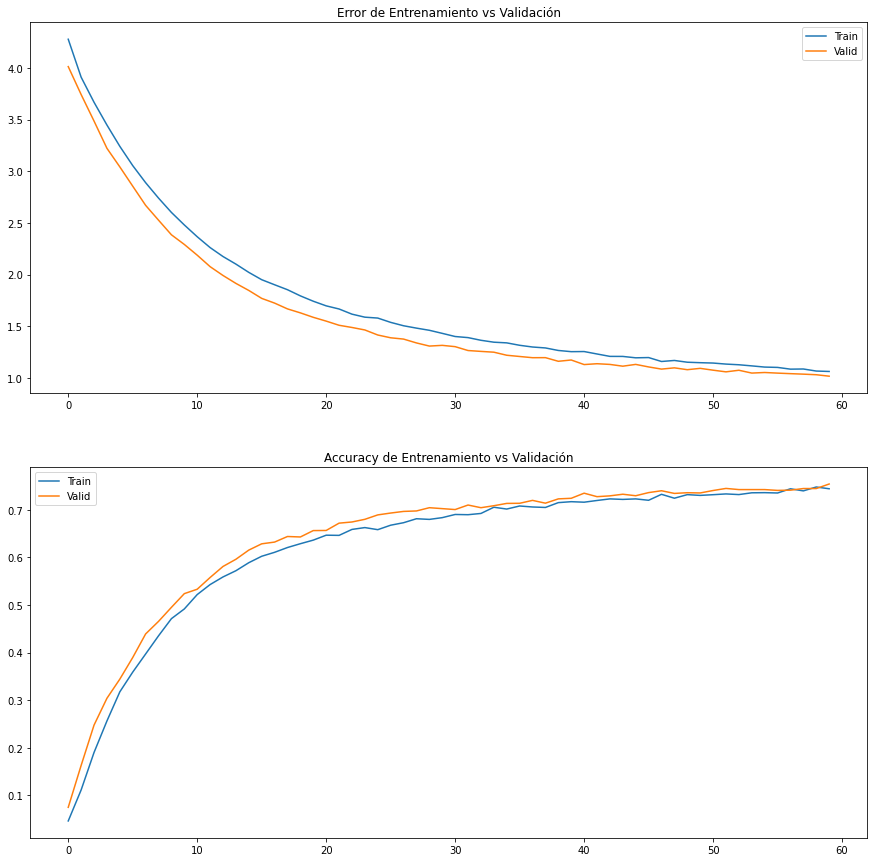

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

### Accuracy en validacion

In [ ]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

accuracy_metric = torchmetrics.Accuracy()
if torch.cuda.is_available():
  accuracy_metric.to("cuda")

for test_data, test_target in valid_loader:
  if torch.cuda.is_available():
        test_data, test_target = test_data.cuda(), test_target.cuda()
  output = resnet50_model(test_data)
  test_loss += criterion(output, test_target).item()
  test_accuracy += accuracy_metric(output, test_target).item()

test_loss = test_loss / len(valid_loader)
test_accuracy = test_accuracy / len(valid_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 1.009044 y una accuracy de 0.750732


## Vision Transformer

In [11]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.6 MB 5.1 MB/s 
     |████████████████████████████████| 101 kB 13.0 MB/s 


In [20]:
DATASET_DIR = 'jpeg-224x224'

TRAIN_DIR  = DATASET_DIR + '/train'
VAL_DIR  = DATASET_DIR + '/val'
TEST_DIR  = DATASET_DIR + '/test'

In [21]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

# train_transform = torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224),
#                                       torchvision.transforms.RandomHorizontalFlip(0.5),
#                                       torchvision.transforms.ToTensor(), normalize])

# valid_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
#                                       torchvision.transforms.ToTensor(), normalize])


# test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize])

train_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

valid_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


train_set = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
valid_set = torchvision.datasets.ImageFolder(VAL_DIR, transform=valid_transform)
test_set = TestDataset(path=TEST_DIR, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=10, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=True, num_workers=2)


# print out some data stats
print('Num training images: ', len(train_set))
print('Num valid images: ', len(valid_set))
print('Num test images: ', len(test_set))

Num training images:  12753
Num valid images:  3712
Num test images:  7382


In [22]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

In [23]:
EPOCHS = 5
BATCH_SIZE = 10
LEARNING_RATE = 2e-5

In [24]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_set.classes))    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 
    
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [9]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_set))
print("Number of valid samples: ", len(valid_set))
print("Detected Classes are: ", train_set.class_to_idx) 

# train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
# test_loader  = data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

# Train the model
for epoch in range(EPOCHS):        
  for step, (x, y) in enumerate(train_loader):
    # Change input array into list with each batch being one element
    x = np.split(np.squeeze(np.array(x)), len(x))
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
    # Send to GPU if available
    x, y  = x.to(device), y.to(device)
    b_x = Variable(x)   # batch x (image)
    b_y = Variable(y)   # batch y (target)
    # Feed through model
    output, loss = model(b_x, None)
    # Calculate loss
    if loss is None: 
      loss = loss_func(output, b_y)   
      optimizer.zero_grad()           
      loss.backward()                 
      optimizer.step()

    if step % 50 == 0:
      # Get the next batch for testing purposes
      test = next(iter(valid_loader))
      test_x = test[0]
      # Reshape and get feature matrices as needed
      test_x = np.split(np.squeeze(np.array(test_x)), len(test_x))
      for index, array in enumerate(test_x):
        test_x[index] = np.squeeze(array)
      test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
      # Send to appropirate computing device
      test_x = test_x.to(device)
      test_y = test[1].to(device)
      # Get output (+ respective class) and compare to target
      test_output, loss = model(test_x, test_y)
      test_output = test_output.argmax(1)
      # Calculate Accuracy
      accuracy = (test_output == test_y).sum().item() / len(test_x)
      print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| valid accuracy: %.2f' % accuracy)

Number of train samples:  12753
Number of valid samples:  3712
Detected Classes are:  {'alpine sea holly': 0, 'anthurium': 1, 'artichoke': 2, 'azalea': 3, 'balloon flower': 4, 'barberton daisy': 5, 'bee balm': 6, 'bird of paradise': 7, 'bishop of llandaff': 8, 'black-eyed susan': 9, 'blackberry lily': 10, 'blanket flower': 11, 'bolero deep blue': 12, 'bougainvillea': 13, 'bromelia': 14, 'buttercup': 15, 'californian poppy': 16, 'camellia': 17, 'canna lily': 18, 'canterbury bells': 19, 'cape flower': 20, 'carnation': 21, 'cautleya spicata': 22, 'clematis': 23, "colt's foot": 24, 'columbine': 25, 'common dandelion': 26, 'common tulip': 27, 'corn poppy': 28, 'cosmos': 29, 'cyclamen ': 30, 'daffodil': 31, 'daisy': 32, 'desert-rose': 33, 'fire lily': 34, 'foxglove': 35, 'frangipani': 36, 'fritillary': 37, 'garden phlox': 38, 'gaura': 39, 'gazania': 40, 'geranium': 41, 'giant white arum lily': 42, 'globe thistle': 43, 'globe-flower': 44, 'grape hyacinth': 45, 'great masterwort': 46, 'hard-le

In [ ]:
torch.save(model, '/content/model_transformer.pt')

In [26]:
MODEL_PATH = '/content/model_transformer_2.pt'
model = torch.load(MODEL_PATH)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

 ## Accuracy en validacion

In [35]:
# Realizo el paso de evaluación computando error y accuracy
test_loss = 0.0
test_accuracy = 0.0

accuracy_metric = torchmetrics.Accuracy()
accuracy_metric.to(device)

for test_data, test_target in valid_loader:

  test_data = test_data.to(device)
  test_target = test_target.to(device)

  prediction, loss = model(test_data, test_target)
  test_loss += loss
  test_accuracy += accuracy_metric(prediction, test_target).item()

test_loss = test_loss / len(valid_loader)
test_accuracy = test_accuracy / len(valid_loader)

print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))

El modelo logro un error de 0.356500 y una accuracy de 0.939516


## Prediccion en muetras de validacion

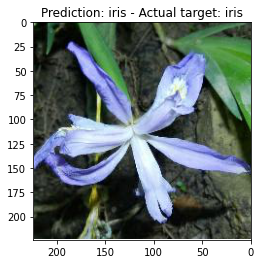

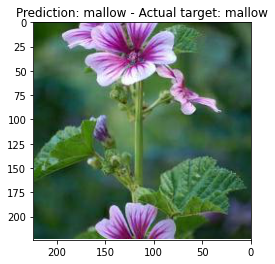

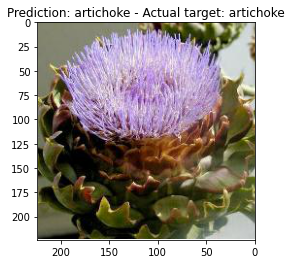

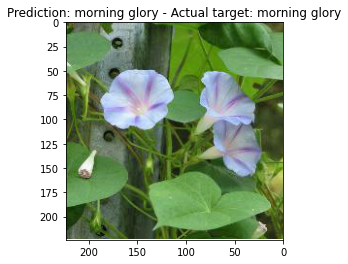

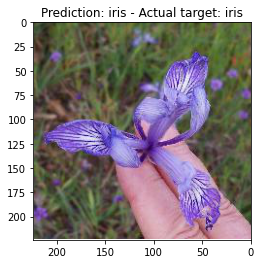

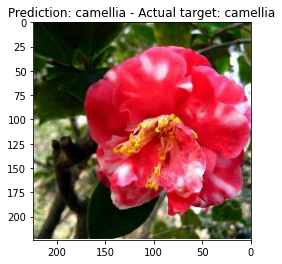

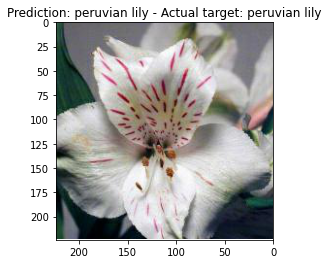

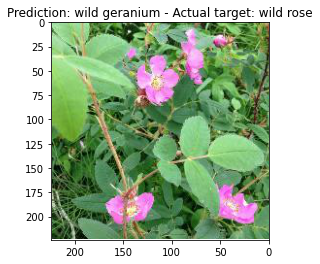

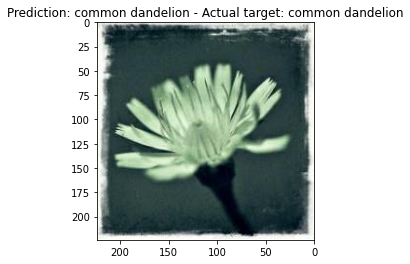

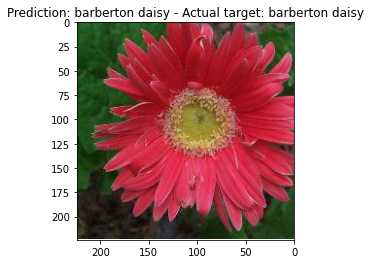

In [33]:
EVAL_BATCH = 1
eval_loader = torch.utils.data.DataLoader(valid_set, batch_size=EVAL_BATCH, shuffle=True, num_workers=2)


# Disable grad
with torch.no_grad():
    iterable = iter(eval_loader)
    for i in range(10):
      inputs, target = next(iterable)
      # Reshape and get feature matrices as needed
      
      inputs = inputs[0].permute(1, 2, 0)
      # Save original Input
      originalInput = inputs
      for index, array in enumerate(inputs):
          inputs[index] = np.squeeze(array)
      inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

      # Send to appropriate computing device
      inputs = inputs.to(device)
      target = target.to(device)

      # Generate prediction
      prediction, loss = model(inputs, target)

      # Predicted class value using argmax
      predicted_class = np.argmax(prediction.cpu())
      value_predicted = list(valid_set.class_to_idx.keys())[list(valid_set.class_to_idx.values()).index(predicted_class)]
      value_target = list(valid_set.class_to_idx.keys())[list(valid_set.class_to_idx.values()).index(target)]

      # Show result
      plt.imshow(originalInput)
      plt.xlim(224,0)
      plt.ylim(224,0)
      plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
      plt.show()

## Prediccion en muestras de test (sin etiquetas)

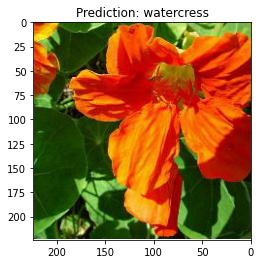

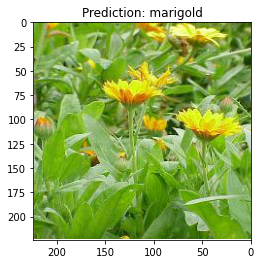

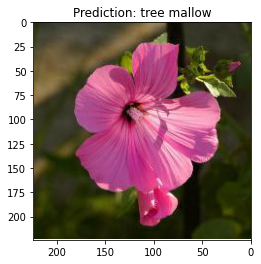

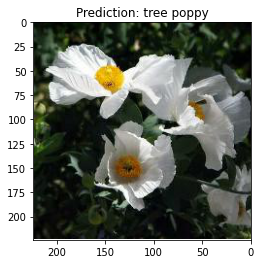

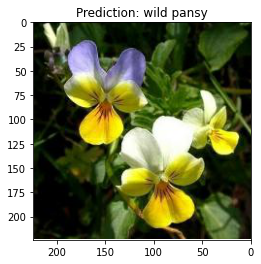

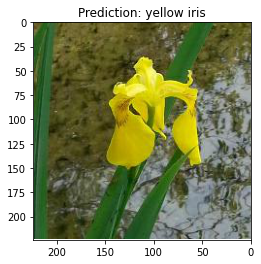

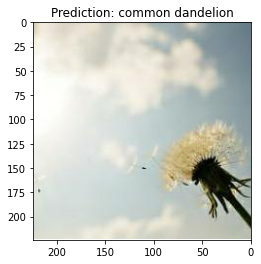

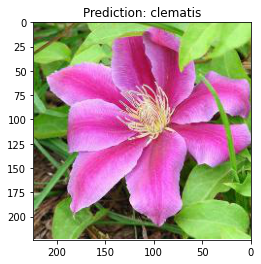

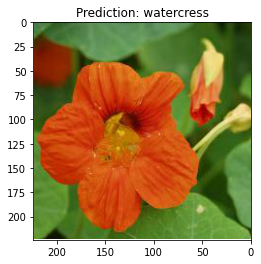

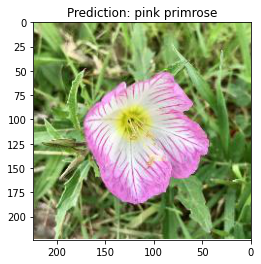

In [32]:
EVAL_BATCH = 1
test_loader = torch.utils.data.DataLoader(test_set, batch_size=EVAL_BATCH, shuffle=True, num_workers=2)


# Disable grad
with torch.no_grad():
  iterable = iter(test_loader)
  for i in range(10):
    inputs = next(iter(iterable))
    # Reshape and get feature matrices as needed
    
    inputs = inputs[0].permute(1, 2, 0)
    # Save original Input
    originalInput = inputs
    for index, array in enumerate(inputs):
      inputs[index] = np.squeeze(array)
    inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

    # Send to appropriate computing device
    inputs = inputs.to(device)
  
    # Generate prediction
    prediction, _ = model(inputs, None)
      
    # Predicted class value using argmax
    predicted_class = np.argmax(prediction.cpu())
    value_predicted = list(valid_set.class_to_idx.keys())[list(valid_set.class_to_idx.values()).index(predicted_class)]
          
    # Show result
    plt.imshow(originalInput)
    plt.xlim(224,0)
    plt.ylim(224,0)
    plt.title(f'Prediction: {value_predicted}')
    plt.show()

# Conclusiones

*   1
*   2
* 3
* 4

